In [1]:
%cd Growing-Neural-Cellular-Automata

/home/pesquisavcl/pesquisa/filipe/automatos/Growing-Neural-Cellular-Automata


In [2]:
%matplotlib inline
import time
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image

from IPython.display import clear_output

from lib.CAModel import CAModel, LCAModel, CCAModel, SAModel,mCAModel_v7
from lib.utils_vis import SamplePool, to_alpha, to_rgb, get_living_mask, make_seed, make_circle_masks
import torch
import os


In [3]:

# def load_emoji(path="C:/Users/andre/OneDrive/Imagens/gato_png.png", target_size=40):
    
#     im = imageio.imread(path, pilmode='RGBA')  
#     emoji = np.array(im.astype(np.float32))
#     emoji = cv2.resize(emoji, (target_size, target_size))
#     emoji /= 255.0
#     return emoji

def load_emoji_v2(path, output_folder, target_size=40 ):

    im = Image.open(path).resize((target_size,target_size))
    # rgb_im = im.convert('RGB')
    rgb_im = im
    path_img_png = os.path.join(output_folder, 'target.png')
    rgb_im.save(path_img_png)
    
    im = imageio.imread(path_img_png, pilmode='RGBA')  
    #im = imageio.imread(path_img_png, pilmode='RGB')  
    im = np.array(im.astype(np.float32))
    # # emoji = cv2.resize(emoji, (target_size, target_size))
    # emoji /= 255.0
    im /= 255.0
    return im

# def load_recorte_target( path="C:/Users/andre/OneDrive/Imagens/gato_png.png", target_size=80, grid_size=40, target_number=0, linhas_target=1, col_target=1):
    
#     im = imageio.imread(path, pilmode='RGBA')  #FILIPE
#     emoji = np.array(im.astype(np.float32))
#     emoji = cv2.resize(emoji, (target_size, target_size))
#     emoji /= 255.0
        
#     start_line = (target_number//linhas_target)*grid_size
#     end_line = start_line + grid_size
    
#     start_col = (target_number%col_target)*grid_size
#     end_col = start_col + grid_size
#     print(start_line, end_line, start_col, end_line)
    
#     emoji = emoji[start_line:end_line, start_col:end_col]
#     # emoji /= 255.0
#     return emoji

def load_recorte_target_v2( path, output_folder, target_size=80, grid_size=40, target_number=0, linhas_target=1, col_target=1):
    
    # im = imageio.imread(path, pilmode='RGBA')  #FILIPE
    # emoji = np.array(im.astype(np.float32))
    # emoji = cv2.resize(emoji, (target_size, target_size))
    # emoji /= 255.0

    emoji = load_emoji_v2(path, output_folder, target_size=target_size )
        
    start_line = (target_number//linhas_target)*grid_size
    end_line = start_line + grid_size
    
    start_col = (target_number%col_target)*grid_size
    end_col = start_col + grid_size
    print(start_line, end_line, start_col, end_line)
    
    emoji = emoji[start_line:end_line, start_col:end_col]
    # emoji /= 255.0
    return emoji


def visualize_batch(x0, x):
    vis0 = to_rgb(x0)
    vis1 = to_rgb(x)
    print('batch (before/after):')
    plt.figure(figsize=[15,5])
    for i in range(x0.shape[0]):
        plt.subplot(2,x0.shape[0],i+1)
        plt.imshow(vis0[i])
        plt.axis('off')
    for i in range(x0.shape[0]):
        plt.subplot(2,x0.shape[0],i+1+x0.shape[0])
        plt.imshow(vis1[i])
        plt.axis('off')
    plt.show()

def plot_loss(loss_log):
    plt.figure(figsize=(10, 4))
    plt.title('Loss history (log10)')
    plt.plot(np.log10(loss_log), '.', alpha=0.1)
    plt.show()

In [5]:
device = torch.device("cuda:0")
# model_checkpoint_folder = "checkpoint/"

CHANNEL_N = 16   # Number of CA state channels
TARGET_PADDING = 0   # Number of pixels used to pad the target image border
TARGET_SIZE = 80
hidden_size = 62
grid_size = 40

lr = 2e-3
lr_gamma = 0.9999
betas = (0.5, 0.5)
# n_epoch = 5000
n_epoch = 200

BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5 #testar com 1.0

step_min = 64
step_max = 96


EXPERIMENT_TYPE = "Growing"

path_input_img = 'data/urso.jpg'

exp_name = "temp"

output_folder = 'outputs'

patches = []


In [6]:
#Dependent parameters

EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch


# exp_name = f"{exp_name}_hs{hidden_size}_ts{TARGET_SIZE}"
output_path = os.path.join(output_folder,exp_name)
                           
if not os.path.exists(output_path): 
    # if the folder directory is not present  
    # then create it. 
    os.makedirs(output_path) 
    
# model_folder = "models/compressNCA_temp1.pth"
model_folder = os.path.join(output_path,'models')

if not os.path.exists(model_folder): 
    # if the folder directory is not present  
    # then create it. 
    os.makedirs(model_folder) 


lin_targets = TARGET_SIZE//40
col_targets = TARGET_SIZE//40

Ntargets = lin_targets * col_targets




In [ ]:
print("Imprimindo patches...")
print(patches)

0 40 0 40
0 40 40 40
40 80 0 80
40 80 40 80


/tmp/ipykernel_17625/3770056213.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(path_img_png, pilmode='RGBA')


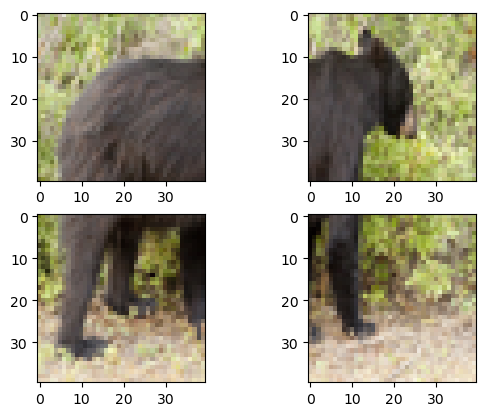

In [8]:
# model_path = "models/compressNCA_temp1.pth"


targets_img = []

fig, axs = plt.subplots(lin_targets, col_targets)


for i in range(Ntargets):
    #target_img = load_recorte_target(path=path_input_img, target_size=TARGET_SIZE, grid_size=grid_size, target_number=i,linhas_target=lin_targets, col_target=col_targets)
    target_img = load_recorte_target_v2(path=path_input_img,output_folder=output_path, target_size=TARGET_SIZE, grid_size=grid_size, target_number=i,linhas_target=lin_targets, col_target=col_targets)
    targets_img.append(target_img)
    
    if Ntargets>1:
        axs[i//lin_targets, i%col_targets].imshow(to_rgb(targets_img[i]))
    else:
        plt.imshow(to_rgb(targets_img[i]))

## Generate image with inference

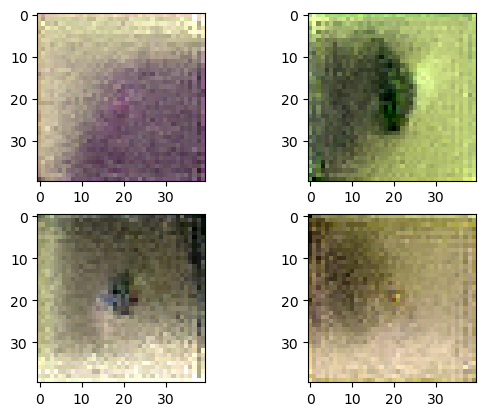

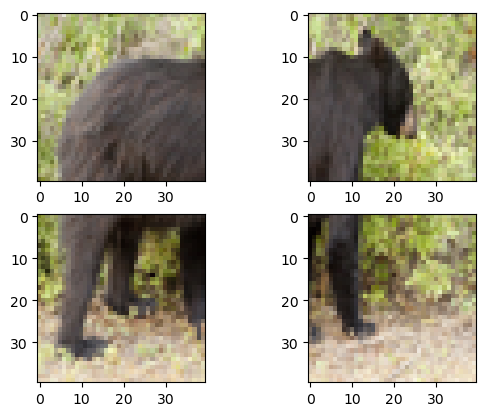

In [11]:
import tqdm


fig1, axs1 = plt.subplots(lin_targets, col_targets)
fig2, axs2 = plt.subplots(lin_targets, col_targets)

output_recortes = []

for id_recorte in range(Ntargets):

    
    mp = os.path.join(model_folder,f"model_p{id_recorte}.pth")
    # loaded_ca = CAModel(CHANNEL_N, CELL_FIRE_RATE, device,hidden_size=hidden_size).to(device)
    loaded_ca = mCAModel_v7(CHANNEL_N, CELL_FIRE_RATE, device,hidden_size=hidden_size).to(device)
    loaded_ca.load_state_dict(torch.load(mp))


    # x = np.zeros([1, TARGET_SIZE, TARGET_SIZE, CHANNEL_N], np.float32)
    x = np.zeros([1, grid_size, grid_size, CHANNEL_N], np.float32)
    
    #seed = make_seed((h, w), CHANNEL_N)
    seed = make_seed((grid_size, grid_size), CHANNEL_N)
    x0 = np.repeat(seed[None, ...], 1, 0)
    x0 = torch.from_numpy(x0.astype(np.float32)).to(device)

    # xf = ca(x0,steps=96)
    # xf = loaded_ca(x0,steps=step_max)
    # import pdb; pdb.set_trace()
    xf = loaded_ca(x0,steps=step_max)

    

    #Filipe's code
    input_rgb = to_rgb(x0.detach().cpu().numpy())
    output_rgb = to_rgb(xf.detach().cpu().numpy())
    target_rgb = to_rgb(target_img)
    
    #unpading
    output_image = output_rgb[0]
    unpad_output_image = output_image[TARGET_PADDING:output_image.shape[0]-TARGET_PADDING, TARGET_PADDING:output_image.shape[1]-TARGET_PADDING]
    output_recortes.append(unpad_output_image)

    axs1[id_recorte//lin_targets, id_recorte%col_targets].imshow(unpad_output_image)
    axs2[id_recorte//lin_targets, id_recorte%col_targets].imshow(to_rgb(targets_img[id_recorte]))

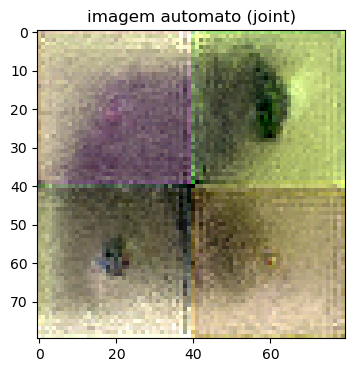

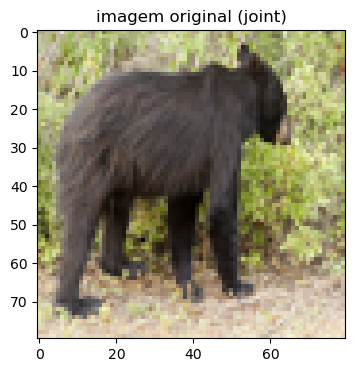

In [12]:

#primeira linha
output_joint = output_recortes[0]
for num_col in range(1, col_targets):
    output_joint = np.concatenate((output_joint, output_recortes[num_col]), axis=1)
    
#proximas linhas
for num_lin in range(1,lin_targets):
    
    temp_joint = output_recortes[num_lin*col_targets]
    for num_col in range(1, col_targets):
        temp_joint = np.concatenate((temp_joint, output_recortes[(num_lin*col_targets)+num_col]), axis=1)
    output_joint = np.concatenate((output_joint, temp_joint), axis=0)


plt.figure(figsize=(4,4))
plt.imshow(output_joint)
plt.title("imagem automato (joint)")
plt.show()

## Target joint

#primeira linha
target_joint = targets_img[0]
for num_col in range(1, col_targets):
    target_joint = np.concatenate((target_joint, targets_img[num_col]), axis=1)
    
#proximas linhas
for num_lin in range(1,lin_targets):
    
    temp_joint = targets_img[num_lin*col_targets]
    for num_col in range(1, col_targets):
        temp_joint = np.concatenate((temp_joint, targets_img[(num_lin*col_targets)+num_col]), axis=1)
    target_joint = np.concatenate((target_joint, temp_joint), axis=0)

plt.figure(figsize=(4,4))
plt.imshow(to_rgb(target_joint))
plt.title("imagem original (joint)")
plt.show()




In [13]:
from PIL import Image

# path_img_automato = "data/mca_v7_urso40_h62.png"
path_img_automato = os.path.join(output_path, 'automato.png')
#path_original = "data/target_mca_urso40.png"
path_original = os.path.join(output_path, 'target.png')

unpad_output_image_ = output_joint * 255
unpad_output_image_ = unpad_output_image_.astype(np.uint8)
im = Image.fromarray(unpad_output_image_)
#im.save("data/automato_cca.png", "PNG")
im.save(path_img_automato, "PNG")


# temp = to_rgb(target_joint)* 255
# temp_ = temp.astype(np.uint8)
# im2 = Image.fromarray(temp_)
# im2.save(path_original, "PNG")

In [14]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from skimage.io import imread


imagem_automato = imread(path_img_automato)
imagem_original = imread(path_original)

mse = mean_squared_error(imagem_original, imagem_automato)
psnr = peak_signal_noise_ratio(imagem_original, imagem_automato)
ssim = structural_similarity(imagem_original, imagem_automato, win_size=3, multichannel=True)


print("[automato]PSNR (Peak Signal-to-Noise Ratio):", psnr)
print("[automato]MSE (Mean Squared Error):", mse)
print("[automato]SSIM (Structural Similarity Index):", ssim)



def tamanho_arquivo(caminho):
    # return os.path.getsize(caminho)
    #print(os.stat(caminho).st_size)
    return os.stat(caminho).st_size



#tamanho_original = tamanho_arquivo(caminho_img_original)
tamanho_original = tamanho_arquivo(path_original)
#tamanho_automato = tamanho_arquivo(caminho_img_automato)
tamanho_automato = tamanho_arquivo(path_img_automato)


print("Tamanho da imagem original:", tamanho_original, "bytes")
print("Tamanho da imagem gerada pelo autômato:", tamanho_automato, "bytes")

def calcular_bits_por_pixel(caminho_imagem, tamanho_arquivo):
    imagem = imread(caminho_imagem)
    largura, altura, _ = imagem.shape
    total_pixels = largura * altura
    bits_por_pixel = (tamanho_arquivo * 8) / total_pixels
    return bits_por_pixel

#bits_por_pixel_original = calcular_bits_por_pixel(caminho_img_original, tamanho_original)
bits_por_pixel_original = calcular_bits_por_pixel(path_original, tamanho_original)
#bits_por_pixel_automato = calcular_bits_por_pixel(caminho_img_automato, tamanho_automato)
bits_por_pixel_automato = calcular_bits_por_pixel(path_img_automato, tamanho_automato)

print("Bits por Pixel da imagem original:", bits_por_pixel_original)
print("Bits por Pixel da imagem gerada pelo autômato:", bits_por_pixel_automato)



# Calculando jpeg para comparação
print("#"*10)
print("\nJPEG...")

from PIL import Image

size = TARGET_SIZE
# im = Image.open("data/trem.jpg")
path_input_img
im = Image.open(path_input_img).resize((size,size))
rgb_im = im.convert('RGB')
path_img_jpg = os.path.join(output_path, 'jpeg.jpg')
#rgb_im.save('data/urso40.jpg', quality=95)
rgb_im.save(path_img_jpg, quality=95)
imagem_jpeg = imread(path_img_jpg)

mse = mean_squared_error(imagem_original, imagem_jpeg)
psnr = peak_signal_noise_ratio(imagem_original, imagem_jpeg)
ssim = structural_similarity(imagem_original, imagem_jpeg, win_size=3, multichannel=True)
tamanho_jpeg = tamanho_arquivo(path_img_jpg)

print("[jpeg]PSNR (Peak Signal-to-Noise Ratio):", psnr)
print("[jpeg]MSE (Mean Squared Error):", mse)
print("[jpeg]SSIM (Structural Similarity Index):", ssim)
print("Tamanho da imagem original:", tamanho_original, "bytes")
print("Tamanho da imagem gerada pelo jpeg:", tamanho_jpeg, "bytes")

# Calculando webP para comparação
print("#"*10)
print("\nWebP...")

im = Image.open(path_input_img).resize((size,size))
path_img_webp = os.path.join(output_path, 'webp.webp')
im.save(path_img_webp, "webp", quality=100)
imagem_webp = imread(path_img_webp)

mse_webp = mean_squared_error(imagem_original, imagem_webp)
psnr_webp = peak_signal_noise_ratio(imagem_original, imagem_webp)
ssim_webp = structural_similarity(imagem_original, imagem_webp, win_size=3, multichannel=True)
tamanho_webp = os.stat(path_img_webp).st_size

print("[webp]PSNR (Peak Signal-to-Noise Ratio):", psnr_webp)
print("[webp]MSE (Mean Squared Error):", mse_webp)
print("[webp]SSIM (Structural Similarity Index):", ssim_webp)
print("Tamanho da imagem original:", tamanho_original, "bytes")
print("Tamanho da imagem gerada pelo webp:", tamanho_webp, "bytes")



[automato]PSNR (Peak Signal-to-Noise Ratio): 17.555177802669498
[automato]MSE (Mean Squared Error): 1141.7278125
[automato]SSIM (Structural Similarity Index): 0.5217331151074854
Tamanho da imagem original: 15363 bytes
Tamanho da imagem gerada pelo autômato: 14836 bytes
Bits por Pixel da imagem original: 19.20375
Bits por Pixel da imagem gerada pelo autômato: 18.545
##########

JPEG...
[jpeg]PSNR (Peak Signal-to-Noise Ratio): 33.14901953809107
[jpeg]MSE (Mean Squared Error): 31.49041666666667
[jpeg]SSIM (Structural Similarity Index): 0.9725670026759724
Tamanho da imagem original: 15363 bytes
Tamanho da imagem gerada pelo jpeg: 5127 bytes
##########

WebP...
[webp]PSNR (Peak Signal-to-Noise Ratio): 34.10774189625287
[webp]MSE (Mean Squared Error): 25.252604166666668
[webp]SSIM (Structural Similarity Index): 0.9819403330919411
Tamanho da imagem original: 15363 bytes
Tamanho da imagem gerada pelo webp: 5502 bytes
